In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils import compute_sample_weight
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Klasifikatori
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn import svm
from xgboost import XGBClassifier

In [2]:
df_final = pd.read_csv('credit_risk_df_final.csv')

In [3]:
df_final_clust = df_final.copy()

In [4]:
data_class_clust = df_final['Target']
data_var_clust = df_final.drop(columns=['Target'])
data_var_clust_scaled = StandardScaler().fit_transform(data_var_clust)

Klasterēšanas pielietošana

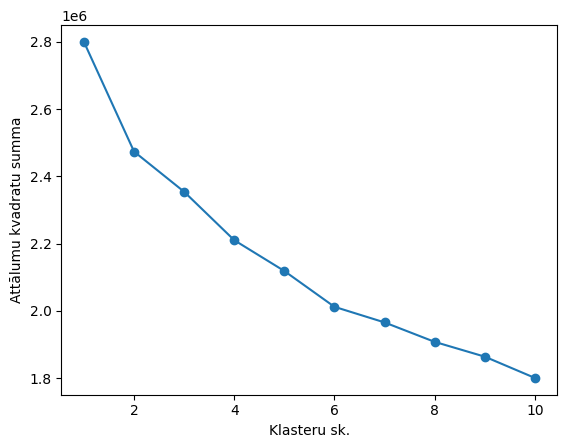

In [98]:
k_range = range(1, 11)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_var_clust_scaled)  
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Klasteru sk.')
plt.ylabel('Attālumu kvadratu summa')
plt.show()

In [5]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(data_var_clust_scaled)

In [6]:
df_final_clust['kmeans_clusters'] = cluster_labels

In [7]:
train_data, test_data = train_test_split(df_final_clust, test_size=0.3, stratify=df_final['Target'], random_state=42)

In [8]:
train_class = train_data['Target']
test_class = test_data['Target']

In [9]:
train_data_var = train_data.drop(columns=['Target'])
test_data_var = test_data.drop(columns=['Target'])

PCA pielietošana

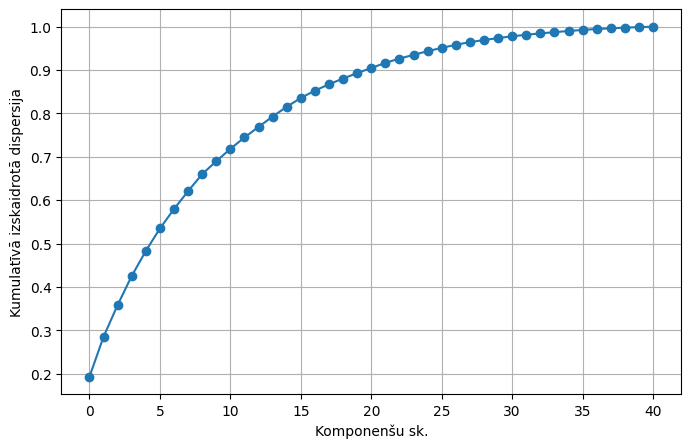

In [150]:
data_var = pd.concat([train_data_var, test_data_var], axis=0)
data_var = StandardScaler().fit_transform(data_var)
pca = PCA()
pca.fit(data_var)  
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Komponenšu sk.')
plt.ylabel('Kumulatīvā izskaidrotā dispersija')
plt.grid()
plt.show()

In [11]:
train_data_var = StandardScaler().fit_transform(train_data_var)
test_data_var = StandardScaler().fit_transform(test_data_var)

In [12]:
pca = PCA(n_components=0.9)
train_data_var_pca = pca.fit_transform(train_data_var)
test_data_var_pca = pca.transform(test_data_var)

In [13]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.1928326 , 0.09204086, 0.07370622, 0.06633285, 0.0574485 ,
       0.05225199, 0.04486571, 0.04112297, 0.03916676, 0.02972265,
       0.02856786, 0.02660258, 0.02431165, 0.02383752, 0.02222063,
       0.02039331, 0.01706572, 0.01472243, 0.0133219 , 0.01259679,
       0.01198867])

Loģistiskā regrsija

In [14]:
model_LR= LogisticRegression(random_state=42, class_weight='balanced') 
model_LR.fit(train_data_var_pca, train_class)
test_class_LR = model_LR.predict(test_data_var_pca)

In [15]:
cm = confusion_matrix(test_class, test_class_LR, normalize='true')
acc = accuracy_score(test_class, test_class_LR)
rec = recall_score(test_class, test_class_LR)
prec = precision_score(test_class, test_class_LR)
f1 = f1_score(test_class, test_class_LR)

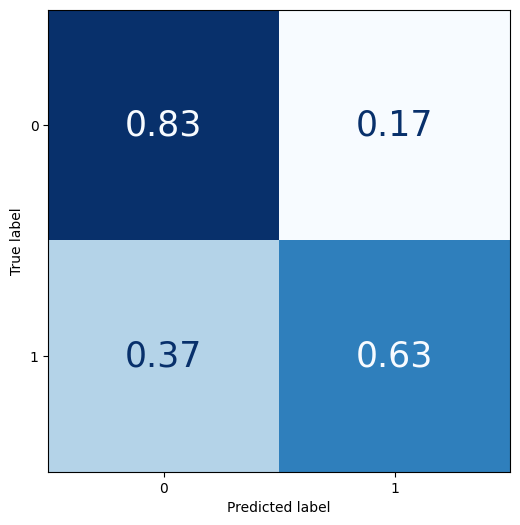

Pareizība:  0.7968281183026147
Atsaukums:  0.6257688572353513
Pricizitāte:  0.3833035891334523
F1:  0.4754058042302017


In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'], )
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.show()

print('Pareizība: ', acc)
print('Atsaukums: ', rec)
print('Pricizitāte: ', prec)
print('F1: ', f1)

Lēmumu koks

In [17]:
model_DT = DecisionTreeClassifier(random_state=42, class_weight='balanced', criterion='entropy', ccp_alpha=0.001)
model_DT.fit(train_data_var_pca, train_class)
test_class_DT = model_DT.predict(test_data_var_pca)

In [18]:
acc_DT = accuracy_score(test_class, test_class_DT)
prec_DT = precision_score(test_class, test_class_DT)
rec_DT = recall_score(test_class, test_class_DT)
f1_DT = f1_score(test_class, test_class_DT)
cm_DT = confusion_matrix(test_class, test_class_DT, normalize='true')

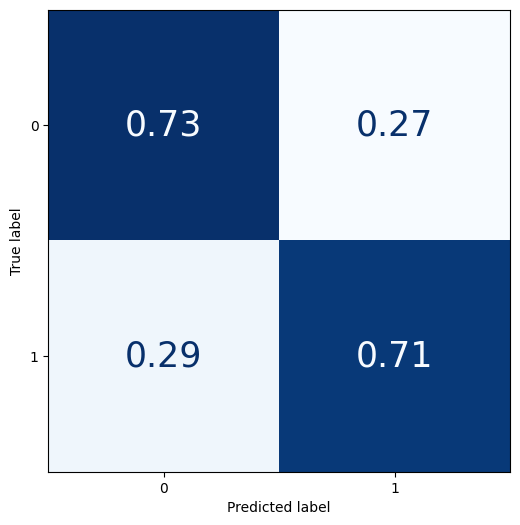

Pareizība:  0.7269609944277754
Atsaukums:  0.7128520556814503
Pricizitāte:  0.3124290578887628
F1:  0.4344480615566736


In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_DT, display_labels=['0', '1'])
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.show()

print('Pareizība: ', acc_DT)
print('Atsaukums: ', rec_DT)
print('Pricizitāte: ', prec_DT)
print('F1: ', f1_DT)

Gadījumu mežs

In [20]:
model_RF = RandomForestClassifier(max_depth=10, min_samples_split=5, class_weight='balanced', criterion='entropy', random_state=42)
model_RF.fit(train_data_var_pca, train_class)
test_class_RF = model_RF.predict(test_data_var_pca)

In [21]:
cm_RF = confusion_matrix(test_class, test_class_RF, normalize='true')
acc_RF = accuracy_score(test_class, test_class_RF)
rec_RF = recall_score(test_class, test_class_RF)
prec_RF = precision_score(test_class, test_class_RF)
f1_RF = f1_score(test_class, test_class_RF)

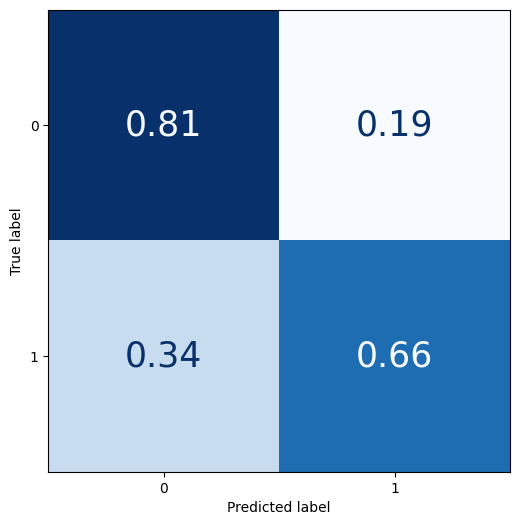

Pareizība:  0.786683811973139
Atsaukums:  0.6633214632567174
Pricizitāte:  0.3733600583090379
F1:  0.4777894368660371


In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=['0', '1'])
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.show()

print('Pareizība: ', acc_RF)
print('Atsaukums: ', rec_RF)
print('Pricizitāte: ', prec_RF)
print('F1: ', f1_RF)

Atbalsta vektora mašīna

In [ ]:
model_SVM = svm.SVC(kernel='rbf', random_state=42, class_weight='balanced')
model_SVM.fit(train_data_var_pca, train_class)
test_class_SVM = model_SVM.predict(test_data_var_pca)

In [24]:
cm_SVM = confusion_matrix(test_class, test_class_SVM, normalize='true')
acc_SVM = accuracy_score(test_class, test_class_SVM)
prec_SVM = precision_score(test_class, test_class_SVM)
rec_SVM = recall_score(test_class, test_class_SVM)
f1_SVM = f1_score(test_class, test_class_SVM)

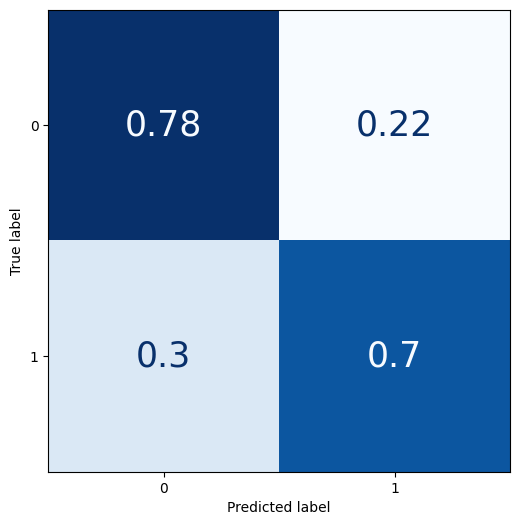

Pareizība:  0.7687288660284802
Atsaukums:  0.6982842343800583
Pricizitāte:  0.3547113961519487
F1:  0.47044711014176666


In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SVM, display_labels=['0', '1'], )
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.show()

print('Pareizība: ', acc_SVM)
print('Atsaukums: ', rec_SVM)
print('Pricizitāte: ', prec_SVM)
print('F1: ', f1_SVM)

Gradienta palielināšanas

In [27]:
model_GB = GradientBoostingClassifier(learning_rate=0.3, max_depth=4, subsample=0.8, random_state=42, n_iter_no_change=10)
model_GB.fit(train_data_var_pca, train_class, sample_weight=compute_sample_weight(class_weight='balanced', y=train_class))
test_class_GB = model_GB.predict(test_data_var_pca)

In [28]:
cm_GB = confusion_matrix(test_class, test_class_GB, normalize='true')
acc_GB = accuracy_score(test_class, test_class_GB)
rec_GB = recall_score(test_class, test_class_GB)
prec_GB = precision_score(test_class, test_class_GB)
f1_GB = f1_score(test_class, test_class_GB)

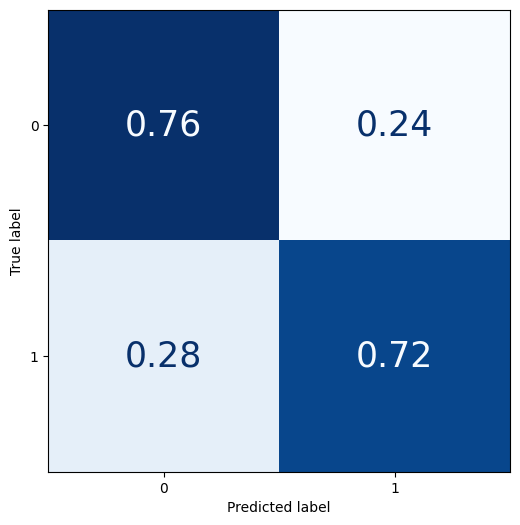

Pareizība:  0.7552507501071581
Atsaukums:  0.716413078666235
Pricizitāte:  0.34172328597899937
F1:  0.46272869837950864


In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_GB, display_labels=['0', '1'], )
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.show()

print('Pareizība: ', acc_GB)
print('Atsaukums: ', rec_GB)
print('Pricizitāte: ', prec_GB)
print('F1: ', f1_GB)

Ekstrēma gradieta palielināšanas

In [30]:
model_XGB = XGBClassifier(learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.5, scale_pos_weight=7, random_state=42)
model_XGB.fit(train_data_var_pca, train_class)
test_class_XGB = model_XGB.predict(test_data_var_pca)

In [31]:
cm_XGB = confusion_matrix(test_class, test_class_XGB, normalize='true')
acc_XGB = accuracy_score(test_class, test_class_XGB)
rec_XGB = recall_score(test_class, test_class_XGB)
prec_XGB = precision_score(test_class, test_class_XGB)
f1_XGB = f1_score(test_class, test_class_XGB)

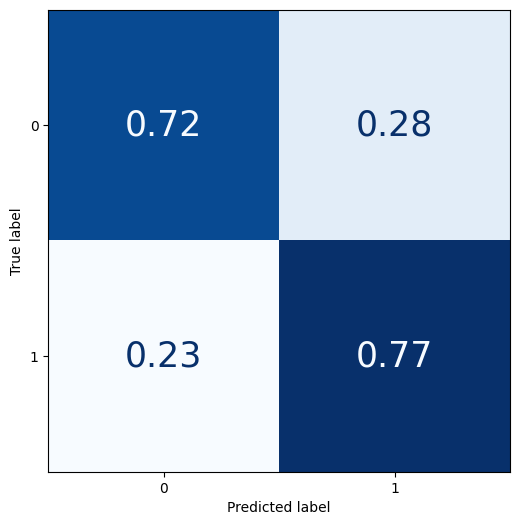

Pareizība:  0.7244368243082345
Atsaukums:  0.7727419876982843
Pricizitāte:  0.31950207468879666
F1:  0.45208333333333334


In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_XGB, display_labels=['0', '1'], )
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.show()

print('Pareizība: ', acc_XGB)
print('Atsaukums: ', rec_XGB)
print('Pricizitāte: ', prec_XGB)
print('F1: ', f1_XGB)

1. metode - VotingClassifier

In [ ]:
estimators = []
estimators.append(('LR', LogisticRegression(random_state=42, class_weight='balanced')))
estimators.append(('RF', RandomForestClassifier(max_depth=3, min_samples_split=5, class_weight='balanced', criterion='entropy', random_state=42))) 
estimators.append(('XGB', XGBClassifier(learning_rate=0.1, max_depth=4, subsample=0.6, colsample_bytree=0.9, scale_pos_weight=8, random_state=42))) 

In [ ]:
model_Voting = VotingClassifier(estimators=estimators, voting='hard', verbose=1) 
model_Voting.fit(train_data_var_pca, train_class)
test_class_Voting = model_Voting.predict(test_data_var_pca)

[Voting] ....................... (1 of 3) Processing LR, total=   0.1s
[Voting] ....................... (2 of 3) Processing RF, total=   9.4s
[Voting] ...................... (3 of 3) Processing XGB, total=   0.4s


In [35]:
acc_Voting = accuracy_score(test_class, test_class_Voting)
prec_Voting= precision_score(test_class, test_class_Voting)
rec_Voting = recall_score(test_class, test_class_Voting)
f1_Voting = f1_score(test_class, test_class_Voting)
cm_Voting = confusion_matrix(test_class, test_class_Voting, normalize='true')

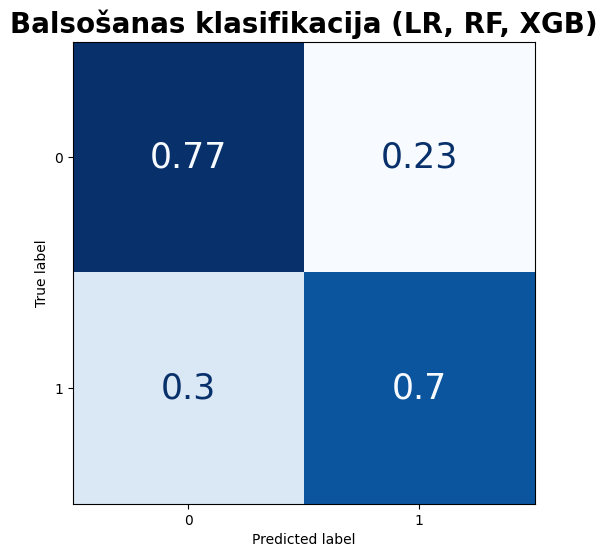

Pareizība:  0.7628232604657809
Atsaukums:  0.6960181288442862
Pricizitāte:  0.3472783072201583
F1:  0.46336206896551724


In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_Voting, display_labels=['0', '1'], )
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.title('Balsošanas klasifikacija (LR, RF, XGB)', fontsize=20, fontweight='bold')
plt.show()

print('Pareizība: ', acc_Voting)
print('Atsaukums: ', rec_Voting)
print('Pricizitāte: ', prec_Voting)
print('F1: ', f1_Voting)

2. metode - StackedClassifier

In [ ]:
base_learners = []
base_learners.append(('LR', LogisticRegression(random_state=42)))
base_learners.append(('RF', RandomForestClassifier(criterion='entropy', min_samples_split=5, random_state=42)))
base_learners.append(('XGB', XGBClassifier(learning_rate=0.01, max_depth=2, subsample=0.6, colsample_bytree=0.7, random_state=42)))
meta_model = RandomForestClassifier(n_estimators=300,max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', bootstrap=True, class_weight='balanced', criterion='gini', random_state=42)  

In [ ]:
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, stack_method='predict_proba', n_jobs=-1)
stacking_model.fit(train_data_var_pca, train_class)
test_class_Stacked = stacking_model.predict(test_data_var_pca)

In [40]:
acc_stacked = accuracy_score(test_class, test_class_Stacked)
prec_stacked = precision_score(test_class, test_class_Stacked)
rec_stacked = recall_score(test_class, test_class_Stacked)
f1_stacked = f1_score(test_class, test_class_Stacked)
cm_stacked = confusion_matrix(test_class, test_class_Stacked, normalize='true')

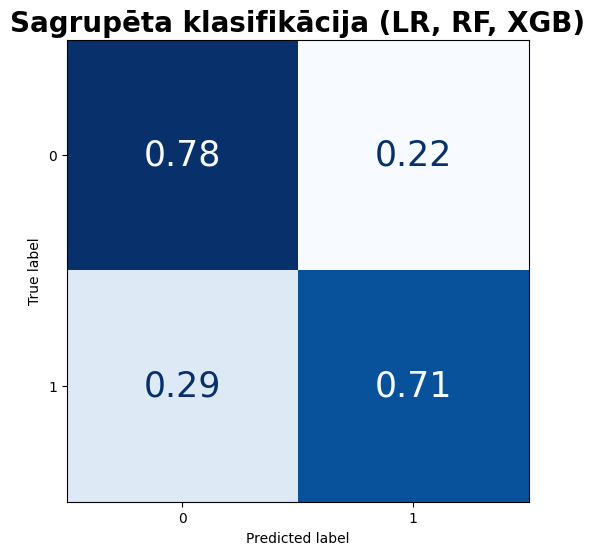

Pareizība:  0.7688241177311045
Atsaukums:  0.7067011977986404
Pricizitāte:  0.356059370412657
F1:  0.4735357917570499


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_stacked, display_labels=['0', '1'], )
fig, ax = plt.subplots(figsize=(8, 6)) 
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
for text in disp.text_.ravel():  
    text.set_fontsize(25)
plt.title('Sakrautā klasifikācija (LR, RF, XGB)', fontsize=20, fontweight='bold')
plt.show()
 
print('Pareizība: ', acc_stacked)
print('Atsaukums: ', rec_stacked)
print('Pricizitāte: ', prec_stacked)
print('F1: ', f1_stacked)

Visas pārpratuma matricas

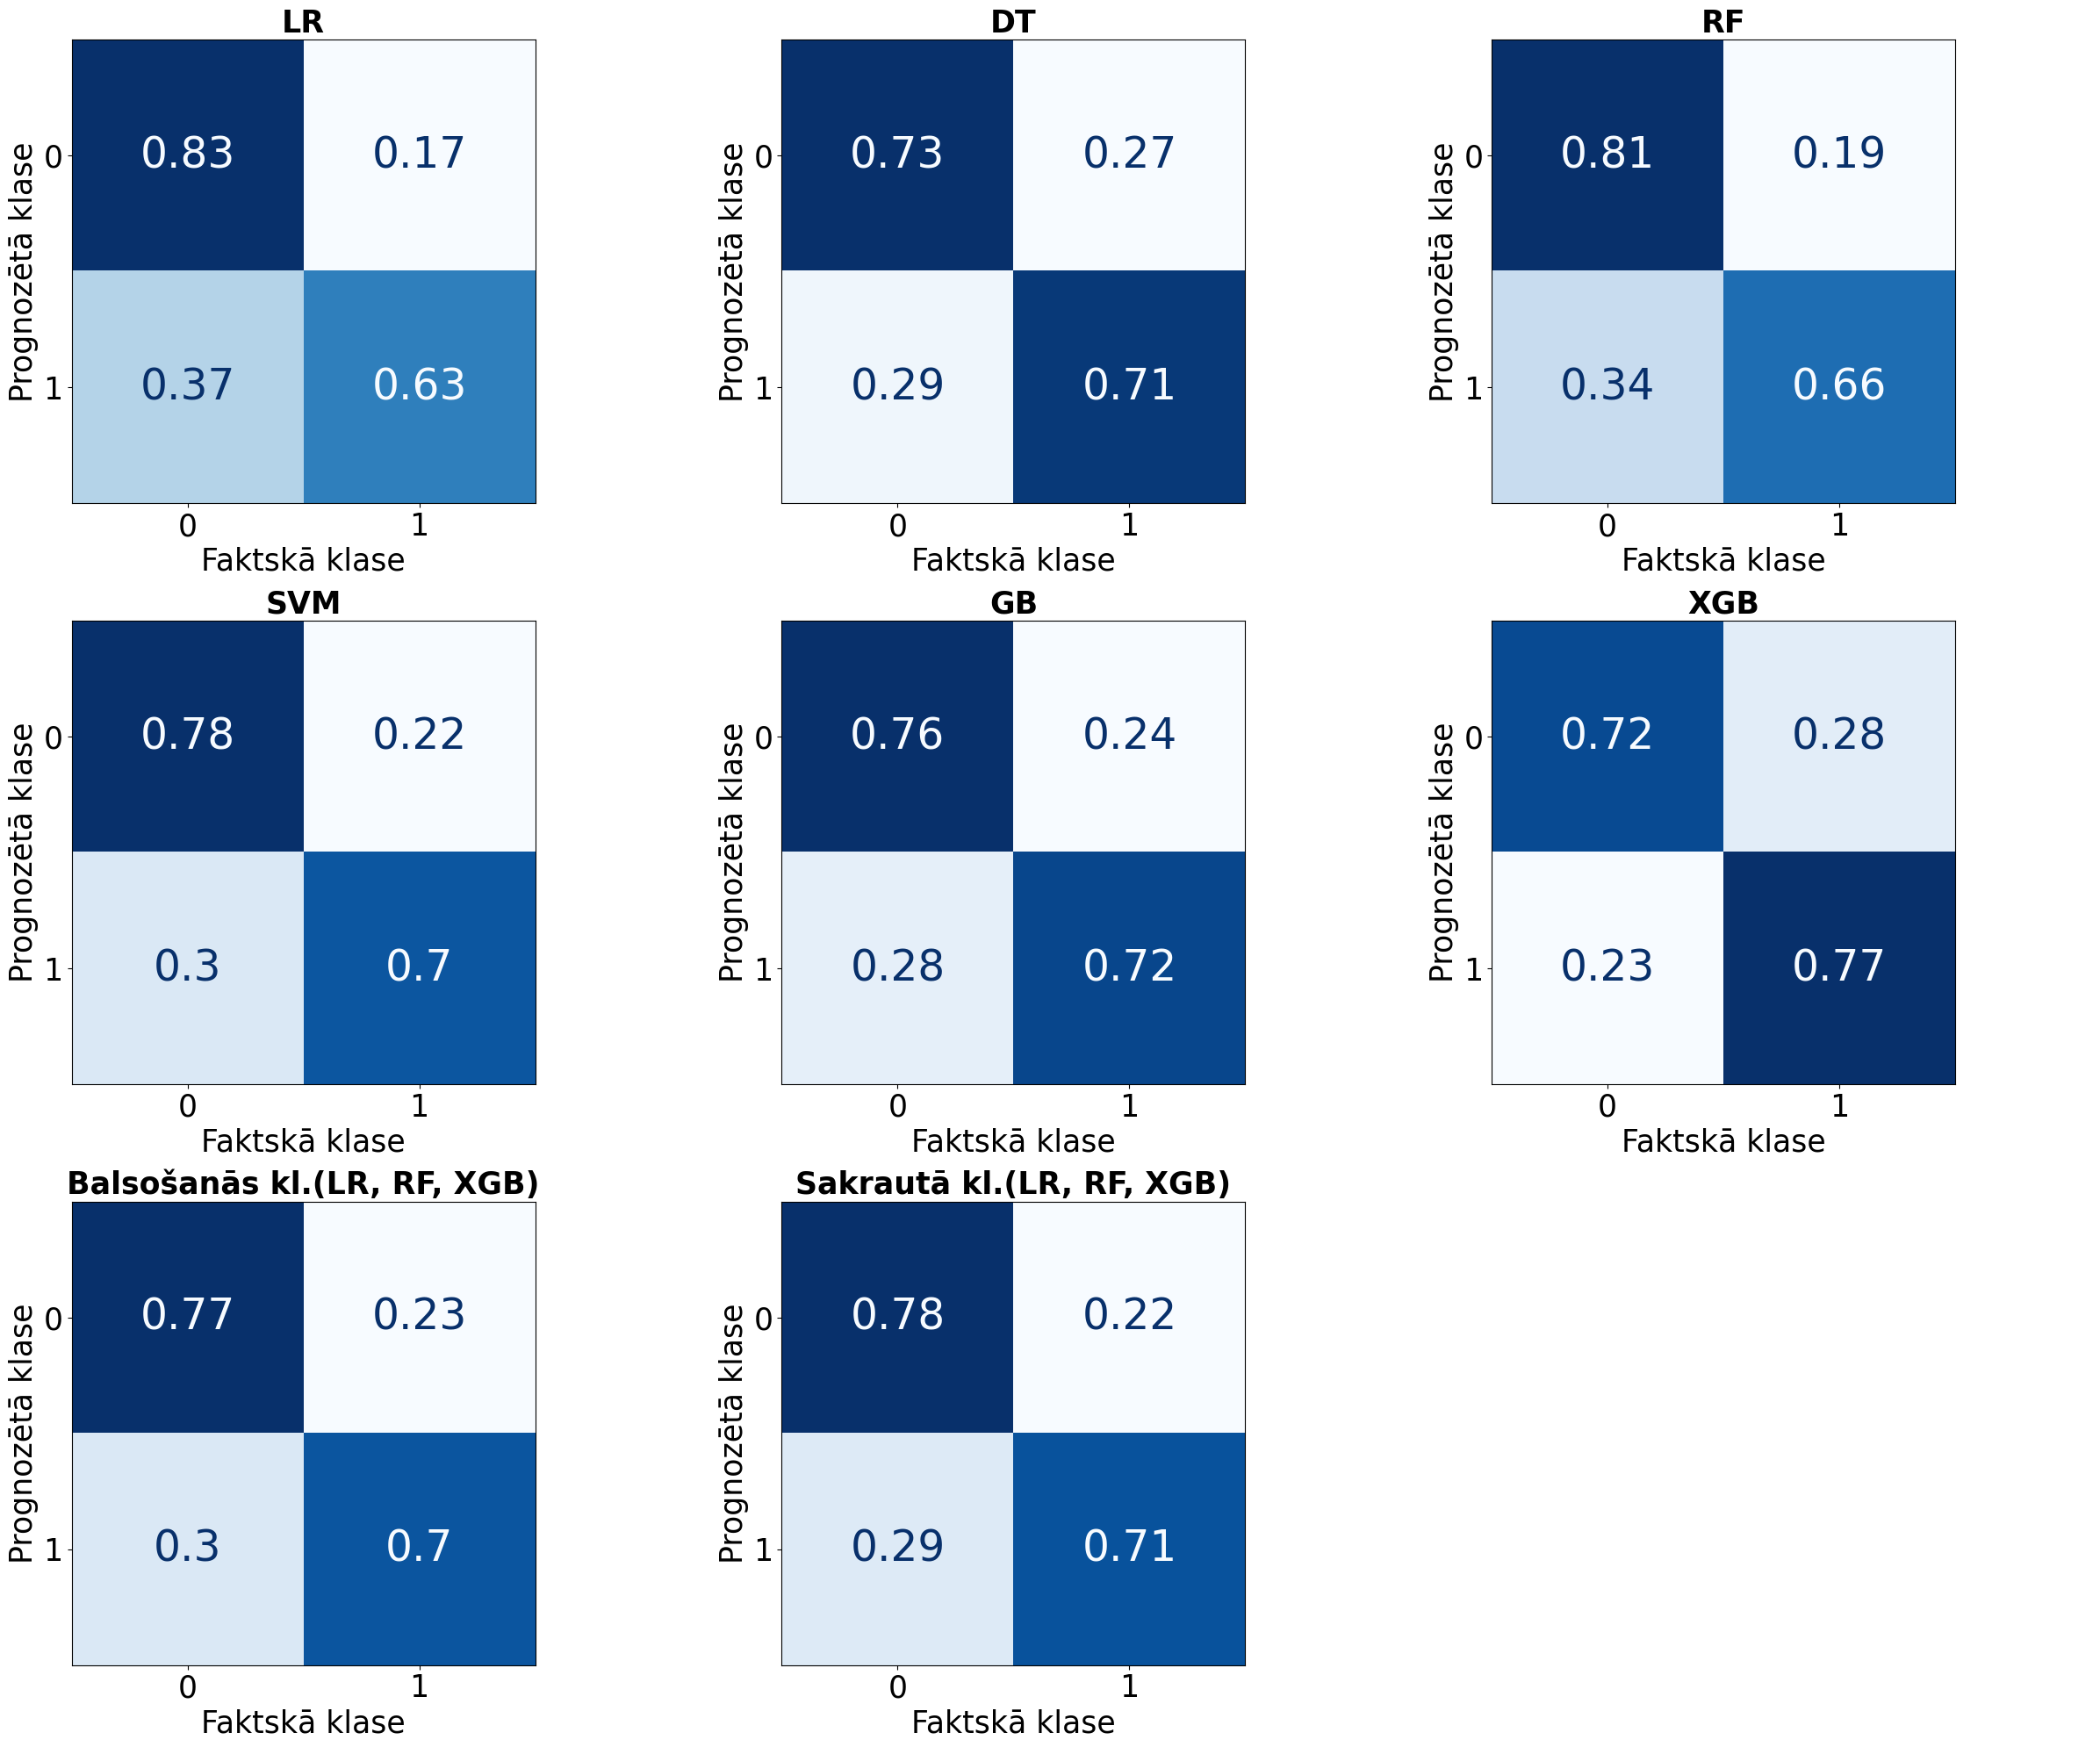

In [ ]:
models = ['LR', 'DT', 'RF', 'SVM', 'GB', 'XGB', 'Balsošanās kl.(LR, RF, XGB)', 'Sakrautā kl.(LR, RF, XGB)']
predictions = [test_class_LR, test_class_DT, test_class_RF, test_class_SVM, test_class_GB, test_class_XGB, test_class_Voting, test_class_Stacked]  
true_labels = test_class 

fig, axes = plt.subplots(3, 3, figsize=(25, 20))  
axes = axes.ravel() 

for i, ax in enumerate(axes[:8]):  
    cm = confusion_matrix(true_labels, predictions[i], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.tick_params(axis='both', labelsize=25)
    for text in disp.text_.ravel():  
        text.set_fontsize(35)
    ax.set_title(models[i], fontsize=25, fontweight='bold')
    ax.set_xlabel('Faktskā klase', fontsize=25)
    ax.set_ylabel('Prognozētā klase', fontsize=25)
    
axes[8].axis('off')
plt.tight_layout()
plt.show()

Visās ROC līknes

In [ ]:
def plot_roc(y_true, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} ROC (AUC = {roc_auc:.3f})')
    return fpr, tpr, thresholds, roc_auc

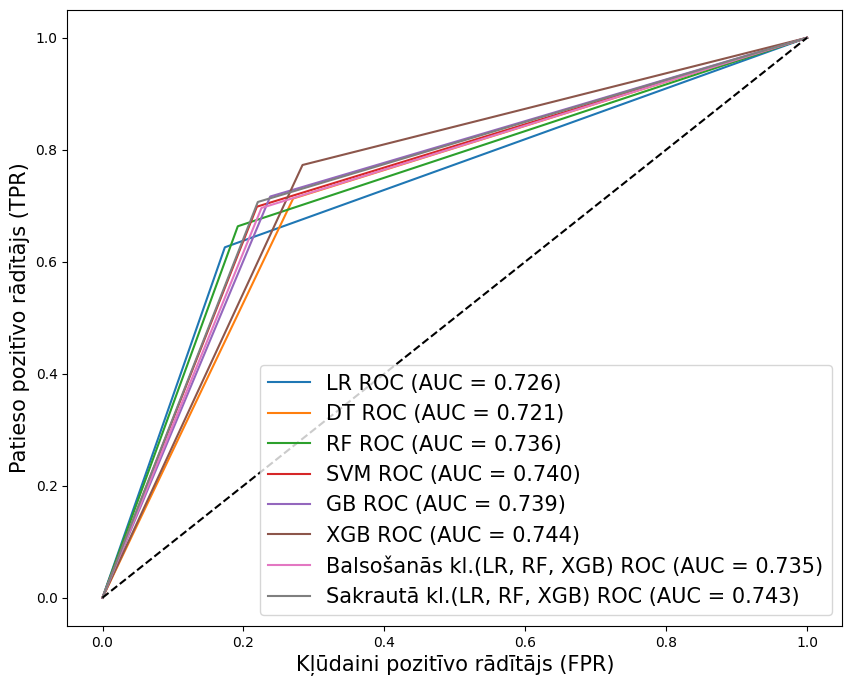

In [45]:
plt.figure(figsize=(10, 8))

plot_roc(y_true=test_class, y_pred=test_class_LR, name='LR')
plot_roc(y_true=test_class, y_pred=test_class_DT, name='DT')
plot_roc(y_true=test_class, y_pred=test_class_RF, name='RF')    
plot_roc(y_true=test_class, y_pred=test_class_SVM, name='SVM')
plot_roc(y_true=test_class, y_pred=test_class_GB, name='GB')
plot_roc(y_true=test_class, y_pred=test_class_XGB, name='XGB')
plot_roc(y_true=test_class, y_pred=test_class_Voting, name='Balsošanās kl.(LR, RF, XGB)')
plot_roc(y_true=test_class, y_pred=test_class_Stacked, name='Sakrautā kl.(LR, RF, XGB)')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Kļūdaini pozitīvo rādītājs (FPR)', fontsize=15)
plt.ylabel('Patieso pozitīvo rādītājs (TPR)', fontsize=15)
plt.legend(loc='lower right', fontsize = 15)
plt.show()